# Importing all libraries necessary for data cleaning 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 

%matplotlib inline

### Loading data file to pandas dataframe and then getting a summary of the data 

In [2]:
df = pd.read_csv(filepath_or_buffer='Building_Permits.csv', header=0,
                     encoding='latin1', low_memory=False)

df.fillna(value=np.nan)
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 43 columns):
Permit Number                             198900 non-null object
Permit Type                               198900 non-null int64
Permit Type Definition                    198900 non-null object
Permit Creation Date                      198900 non-null object
Block                                     198900 non-null object
Lot                                       198900 non-null object
Street Number                             198900 non-null int64
Street Number Suffix                      2216 non-null object
Street Name                               198900 non-null object
Street Suffix                             196132 non-null object
Unit                                      29479 non-null float64
Unit Suffix                               1961 non-null object
Description                               198610 non-null object
Current Status                            198900 n

(198900, 43)

##### After loading the data into a dataframe and using the info method for dataframes, there are multiple columns with messing entries. There are a total of 43 columns and 198,900 entries. The next step is to convert these columns to the correct data type. 

### Functions used for cleaning 

In [3]:
def to_category(columns, dataframe):
    """Convert a list of columns, from a dataframe, to a category datatype"""
    for column in columns: 
        dataframe[column] = dataframe[column].astype('category')

def to_integer(columns, dataframe):
    """Convert columns from a dataframe to an int64 datatype"""
    for column in columns: 
        dataframe[column] = dataframe[column].astype('int64')

#### Rename column names

In [4]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.rename(columns={'neighborhoods_-_analysis_boundaries': 'neighborhoods',
                       'voluntary_soft-story_retrofit': 'voluntary_soft_story_retrofit'},
              inplace=True)
df.columns

Index(['permit_number', 'permit_type', 'permit_type_definition',
       'permit_creation_date', 'block', 'lot', 'street_number',
       'street_number_suffix', 'street_name', 'street_suffix', 'unit',
       'unit_suffix', 'description', 'current_status', 'current_status_date',
       'filed_date', 'issued_date', 'completed_date',
       'first_construction_document_date', 'structural_notification',
       'number_of_existing_stories', 'number_of_proposed_stories',
       'voluntary_soft_story_retrofit', 'fire_only_permit',
       'permit_expiration_date', 'estimated_cost', 'revised_cost',
       'existing_use', 'existing_units', 'proposed_use', 'proposed_units',
       'plansets', 'tidf_compliance', 'existing_construction_type',
       'existing_construction_type_description', 'proposed_construction_type',
       'proposed_construction_type_description', 'site_permit',
       'supervisor_district', 'neighborhoods', 'zipcode', 'location',
       'record_id'],
      dtype='object')

#### Columns that should be datetime: Creation Date, Current Status Date, Filed Date, Issued Date, Completed Date, First Construction Document Date, Permit Expiration Date
#### Columns that should be categorical: Permit Type, Permit Type Definition, Street Name (Possibly; otherwise no change needed), Current Status, Fire Only Permit, Existing Use, Proposed Use, Existing Construction Type, Existing Construction Type Description, Proposed Construction Type, Proposed Construction Type Description, Supervisor District, Neighborhoods - Analysis Boundaries, Zipcode, TIDF Compliance 

### Filling in data for mising category columns 

In [5]:
cols_category = {'permit_type':'unknown', 'permit_type_definition':'unknown', 'street_name':'unknown', 
        'current_status':'unknown', 'fire_only_permit':'unknown', 'existing_use':'unknown', 
        'proposed_use':'unknown', 'existing_construction_type':'unknown',
        'existing_construction_type_description':'unknown', 'proposed_construction_type':'unknown',
        'proposed_construction_type_description':'unknown', 'supervisor_district':'unknown', 'neighborhoods':'unknown',
        'zipcode':'unknown', 'tidf_compliance':'unknown', 'site_permit':'unknown', 'unit':'unknown'}

df.fillna(value=cols_category, inplace=True)

###### Adding an address column that combines all relevant address info from dataset

In [6]:
cols = ['street_number','street_name']
for col in cols: 
    df[col] = df[col].astype('str')

df['address'] = df.street_number + " " + df.street_name + " " + df.zipcode.astype('str') + " " + df.unit.astype('str') + " " + df.block

###### Fixing location data syntax and adding separate columns for lat and long 

In [7]:
df['location'] = df['location'].str.replace(" ","").str.strip('(').str.strip(')')
df['latitude'] = df['location'].str.split(',').str[0]
df['longitude'] = df['location'].str.split(',').str[1]
 
df[['latitude','longitude']] = df[['latitude','longitude']].apply(pd.to_numeric)

###### Fixing category columns 

In [8]:
category_cols = ['permit_type_definition', 'current_status',
                 'fire_only_permit','existing_use', 'proposed_use',
                 'existing_construction_type_description',
                 'proposed_construction_type_description', 'neighborhoods',
                 'tidf_compliance', 'site_permit', 'permit_type',
                 'existing_construction_type','proposed_construction_type',
                 'supervisor_district','zipcode']
       
to_category(columns=(category_cols), dataframe=df)

###### Fix columns with dates 

In [9]:
cols = ['permit_creation_date', 'current_status_date','filed_date',
        'issued_date', 'completed_date', 'first_construction_document_date',
        'permit_expiration_date']

for col in cols:
    df[col] = pd.to_datetime(df[col])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 46 columns):
permit_number                             198900 non-null object
permit_type                               198900 non-null category
permit_type_definition                    198900 non-null category
permit_creation_date                      198900 non-null datetime64[ns]
block                                     198900 non-null object
lot                                       198900 non-null object
street_number                             198900 non-null object
street_number_suffix                      2216 non-null object
street_name                               198900 non-null object
street_suffix                             196132 non-null object
unit                                      198900 non-null object
unit_suffix                               1961 non-null object
description                               198610 non-null object
current_status                      

The datatypes for every column has been fixed. We can now look into the data and drop rows and columns as necessary. 

## Dropping selected rows and columns from dataset 
###### See how many null values there are 

In [11]:
df.isnull().sum().sort_values()

permit_number                                  0
tidf_compliance                                0
existing_construction_type                     0
fire_only_permit                               0
existing_construction_type_description         0
proposed_construction_type                     0
proposed_construction_type_description         0
site_permit                                    0
supervisor_district                            0
neighborhoods                                  0
zipcode                                        0
filed_date                                     0
current_status_date                            0
current_status                                 0
unit                                           0
record_id                                      0
street_name                                    0
address                                        0
street_number                                  0
lot                                            0
block               

###### Columns that can be dropped are voluntary_soft_story_retrofit, unit_suffix, street_number_suffix, structural_notification, street_suffix

In [12]:
df.drop(columns=['voluntary_soft_story_retrofit','unit_suffix','street_number_suffix',
                 'structural_notification','street_suffix', 'completed_date',
                 'permit_number','record_id','first_construction_document_date'],
                 inplace=True)

###### Dropping nan value rows in issued date

In [13]:
df.dropna(subset=['issued_date'], how='any', inplace=True)
df = df.reset_index()
df.isnull().sum().sort_values()

index                                         0
existing_construction_type                    0
tidf_compliance                               0
proposed_construction_type_description        0
site_permit                                   0
proposed_use                                  0
supervisor_district                           0
existing_use                                  0
neighborhoods                                 0
zipcode                                       0
fire_only_permit                              0
existing_construction_type_description        0
issued_date                                   0
address                                       0
current_status_date                           0
current_status                                0
unit                                          0
street_name                                   0
street_number                                 0
lot                                           0
block                                   

## Analysis for outliers in dataset

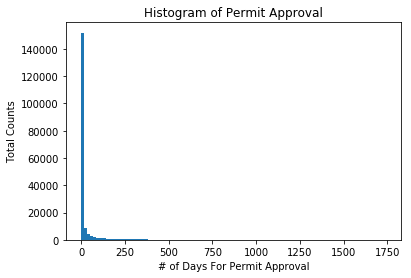

In [14]:
%matplotlib inline

df['time_range'] = (df['issued_date'].sub(df['filed_date'], axis=0))/np.timedelta64(1, 'D')
plt.title('Histogram of Permit Approval')
plt.xlabel('# of Days For Permit Approval')
plt.ylabel('Total Counts')
plt.hist(x=df['time_range'], bins=100)
plt.show()

The plot shows that over 50% of the permits were approved on the same day. Even though there are a lot of same day approvals, it seems highly implausible that the city of San Francisco would approve a building permit on the same day.  

In [15]:
df2 = df.groupby(by=['location','index','filed_date','issued_date','time_range']).size()
df2

location                                index   filed_date  issued_date  time_range
37.70816952820484,-122.4495824817392    6766    2013-03-13  2013-03-13   0.0           1
                                        20954   2013-08-08  2013-08-08   0.0           1
37.70817427088525,-122.46354383455132   24780   2013-09-13  2013-09-19   6.0           1
                                        60090   2014-09-05  2014-09-05   0.0           1
37.7082011113186,-122.46030421092122    158954  2017-06-08  2017-06-08   0.0           1
37.70820204855604,-122.45808060383742   139732  2016-10-14  2016-10-14   0.0           1
37.708204600085985,-122.4630562449027   73498   2015-01-22  2015-01-22   0.0           1
37.708219005746415,-122.46360939461846  105273  2015-11-09  2015-11-09   0.0           1
                                        106465  2015-11-18  2015-11-18   0.0           1
37.708219784150785,-122.43911130693756  165542  2017-11-20  2017-11-20   0.0           1
37.708226716717746,-122.43

In [16]:
df.shape

(183960, 39)

In [17]:
df.to_csv(path_or_buf='Building_Permits_Cleaned.csv', date_format='%Y/%m/%d')

###### Dataset has been cleaned